<a href="https://colab.research.google.com/github/NarenChittem/GlobalStudiesFinal/blob/main/MBBKaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

!pip install -q -U watermark

!pip install -qq transformers

!pip install pyspellchecker

%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Tue May 16 04:54:55 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    43W / 300W |   7568MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -qq transformers

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.10.11
IPython version      : 7.34.0

numpy       : 1.22.4
pandas      : 1.5.3
torch       : 2.0.0+cu118
transformers: 4.29.1



## Data Exploration

We'll load the Google Play app reviews dataset, that we've put together in the previous part:

In [ ]:
import os
import pandas as pd

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# File path of the CSV files
csv_folder = '/content/drive/MyDrive/archive/'

# Read data from the uploaded dataset files
processed_positive_df = pd.read_csv(os.path.join(csv_folder, 'processedPositive.csv'), header=None)
processed_negative_df = pd.read_csv(os.path.join(csv_folder, 'processedNegative.csv'), header=None)
processed_neutral_df = pd.read_csv(os.path.join(csv_folder, 'processedNeutral.csv'), header=None)

# Reshape the dataframes
processed_positive_df = processed_positive_df.transpose().dropna()
processed_negative_df = processed_negative_df.transpose().dropna()
processed_neutral_df = processed_neutral_df.transpose().dropna()

# Add labels to the dataframes
processed_positive_df['labels'] = 2
processed_negative_df['labels'] = 1
processed_neutral_df['labels'] = 0

# Concatenate the dataframes
df = pd.concat([processed_positive_df, processed_negative_df, processed_neutral_df], ignore_index=True)
df.columns = ['tweet_text', 'labels']  # Assign column names


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.head()

,tweet_text,labels
0,An inspiration in all aspects: Fashion,2
1,fitness,2
2,beauty and personality. :)KISSES TheFashionIcon,2
3,Apka Apna Awam Ka Channel Frankline Tv Aam Adm...,2
4,Beautiful album from the greatest unsung guit...,2


In [ ]:
label_counts = df['labels'].value_counts()
print(label_counts)

0    1569
2    1183
1    1116
Name: labels, dtype: int64


## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [ ]:
import torch
from transformers import BertModel, BertTokenizer
from spellchecker import SpellChecker

# Set the pre-trained model name
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

# Create an instance of the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Create an instance of the BERT model
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

# Function to correct spelling errors
def correct_spelling(text):
    spell = SpellChecker()
    words = text.split()
    corrected_words = []
    for word in words:
        corrected_word = spell.correction(word)
        corrected_words.append(corrected_word)
    return ' '.join(corrected_words)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
MAX_LEN = 160

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [ ]:
from torch.utils.data import Dataset

class TwitterDataset(Dataset):
    def __init__(self, tweets, labels, tokenizer, max_len):
        self.tweets = tweets
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.tweets)

    def __getitem__(self, item):
        tweet = str(self.tweets[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            truncation=True, 
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'tweet_text': tweet,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [ ]:
from sklearn.model_selection import train_test_split
import random

RANDOM_SEED = random.randint(1, 1000)
df_train, df_test = train_test_split(df, test_size=0.3, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.3, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((2707, 2), (812, 2), (349, 2))

We also need to create a couple of data loaders. Here's a helper function to do it:

In [ ]:
from torch.utils.data import DataLoader

def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = TwitterDataset(
      tweets=df.tweet_text.to_numpy(),
      labels=df.labels.to_numpy(),
      tokenizer=tokenizer,
      max_len=max_len
  )

  return DataLoader(
      ds,
      batch_size=batch_size,
      num_workers=4
  )


In [ ]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweet_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['labels'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
import torch.nn as nn

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    outputs = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
    )
    pooled_output = outputs.pooler_output
    output = self.drop(pooled_output)
    return self.out(output)


In [ ]:
import torch
import torch.nn as nn
from transformers import BertModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = ['positive', 'negative', 'neutral']
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


In [ ]:
import torch.nn.functional as F

F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3679, 0.4651, 0.1670],
        [0.2082, 0.5862, 0.2057],
        [0.3421, 0.4625, 0.1953],
        [0.2581, 0.4454, 0.2965],
        [0.2869, 0.5302, 0.1829],
        [0.3722, 0.4225, 0.2052],
        [0.3291, 0.4787, 0.1923],
        [0.3446, 0.4928, 0.1626],
        [0.1972, 0.6448, 0.1580],
        [0.4130, 0.4402, 0.1467],
        [0.2682, 0.5992, 0.1326],
        [0.3549, 0.5274, 0.1177],
        [0.2911, 0.5335, 0.1754],
        [0.3331, 0.4452, 0.2217],
        [0.4425, 0.3907, 0.1668],
        [0.5289, 0.3024, 0.1687]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Training

In [ ]:
import torch.optim as optim
from transformers import get_linear_schedule_with_warmup
import torch.nn as nn

EPOCHS = 10

optimizer = optim.AdamW(model.parameters(), lr=2e-5)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
import torch
import numpy as np
import torch.nn as nn

def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets.flatten()) # Updated: Flatten targets - reverse if it is not working

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
from collections import defaultdict
import torch
import numpy as np
from tqdm import tqdm
import time

start_time = time.time()

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Train loss 0.5669083113617757 accuracy 0.7462135205024012
Val   loss 0.239552804542815 accuracy 0.9076354679802956

Epoch 2/10
----------
Train loss 0.1735405218869667 accuracy 0.9386775027705947
Val   loss 0.24393407863510005 accuracy 0.9261083743842364

Epoch 3/10
----------
Train loss 0.0816108605985338 accuracy 0.9722940524565941
Val   loss 0.3156806156381636 accuracy 0.9174876847290641

Epoch 4/10
----------
Train loss 0.03442141824052669 accuracy 0.9903952715182859
Val   loss 0.35956328831026424 accuracy 0.9261083743842364

Epoch 5/10
----------
Train loss 0.01307168925071464 accuracy 0.995567048393055
Val   loss 0.38305795271983645 accuracy 0.9334975369458128

Epoch 6/10
----------
Train loss 0.003827673649271567 accuracy 0.9988917620982638
Val   loss 0.44908611713075447 accuracy 0.9347290640394089

Epoch 7/10
----------
Train loss 0.003966076550269089 accuracy 0.9985223494643517
Val   loss 0.4524723344973823 accuracy 0.9322660098522167

Epoch 8/10
--------

Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

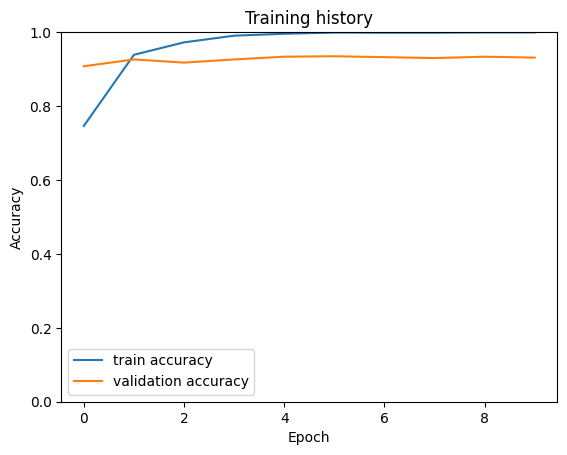

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

train_acc = [acc.cpu().numpy() for acc in history['train_acc']]
val_acc = [acc.cpu().numpy() for acc in history['val_acc']]

plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

plt.show()


The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

In [ ]:
# !gdown --id 1V8itWtowCYnb2Bc9KlK9SxGff9WwmogA

# model = SentimentClassifier(len(class_names))
# model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.9369627507163324

In [ ]:
import os

# Define the file path for saving the model
save_path = "./mbb.pth"
torch.save(model.state_dict(), save_path)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SentimentClassifier(len(class_names))
model = model.to(device)

load_path = "./mbb.pth"
model.load_state_dict(torch.load(load_path, map_location=device))

model.eval()



test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

test_data = next(iter(test_data_loader))
test_data = {key: val.to(device) for key, val in test_data.items() if key != 'tweet_text'}


test_acc, test_loss = eval_model(model, test_data_loader, loss_fn, device, len(df_test))
print(f'Test loss: {test_loss}, Test accuracy: {test_acc}')



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Test loss: 0.45766265245269594, Test accuracy: 0.9369627507163324


The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  twitter_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["tweet_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      twitter_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return twitter_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_twitter_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    positive       0.96      0.97      0.97       145
    negative       0.93      0.93      0.93       105
     neutral       0.91      0.89      0.90        99

    accuracy                           0.94       349
   macro avg       0.93      0.93      0.93       349
weighted avg       0.94      0.94      0.94       349



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

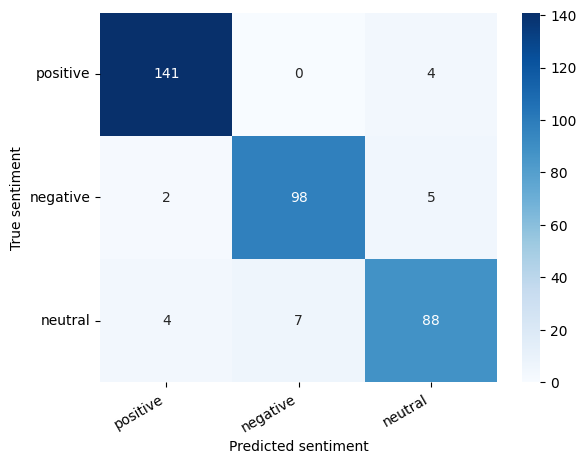

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix


def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [ ]:
idx = 2

twitter_text = y_twitter_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
import textwrap

print("\n".join(textwrap.wrap(twitter_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

My only one cat yang manja sangat and now someone has took him unhappy

True sentiment: negative


Now we can look at the confidence of each sentiment of our model:

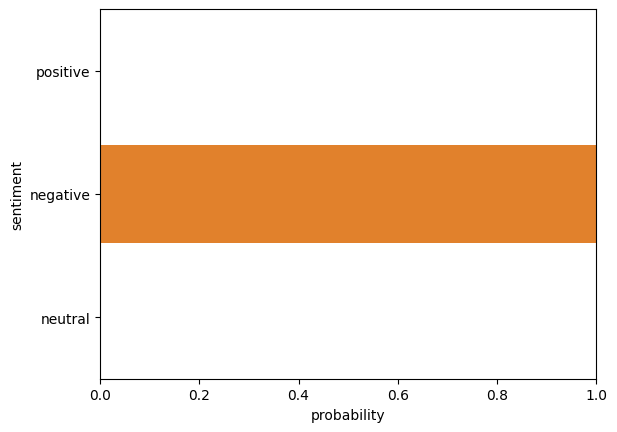

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);